## Prepare Notebook

In [1]:
import numpy as np
import pandas as pd
import tensorflow.compat.v2 as tf
tf.enable_v2_behavior()
import tensorflow_probability as tfp
tfd = tfp.distributions

# Data Viz. 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': '.9', 'grid.color': '.8'}
)
sns.set_palette(palette='deep')
sns_c = sns.color_palette(palette='deep')
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 100

In [2]:
print(tf.__version__)
print(tfp.__version__)

2.1.0
0.9.0


## Distributions

In [3]:
normal = tfd.Normal(loc=0.0, scale=1.0)
gamma = tfd.Gamma(concentration=5.0, rate=1.0)
poisson = tfd.Poisson(rate=2.0)
laplace = tfd.Laplace(loc=0.0, scale=1.0)

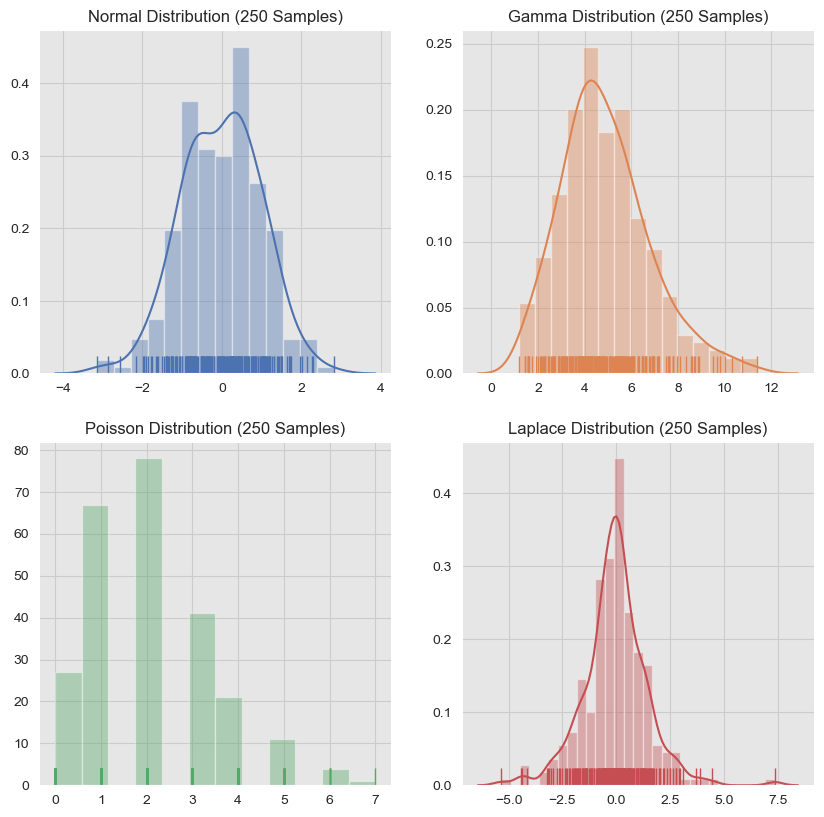

In [4]:
n_samples = 250

fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

sns.distplot(a=normal.sample(n_samples), color=sns_c[0], rug=True, ax=axes[0])
axes[0].set(title=f'Normal Distribution ({n_samples} Samples)')

sns.distplot(a=gamma.sample(n_samples), color=sns_c[1], rug=True, ax=axes[1])
axes[1].set(title=f'Gamma Distribution ({n_samples} Samples)');

sns.distplot(a=poisson.sample(n_samples), color=sns_c[2], kde=False, rug=True, ax=axes[2])
axes[2].set(title=f'Poisson Distribution ({n_samples} Samples)');

sns.distplot(a=laplace.sample(n_samples), color=sns_c[3], rug=True, ax=axes[3])
axes[3].set(title=f'Laplace Distribution ({n_samples} Samples)');

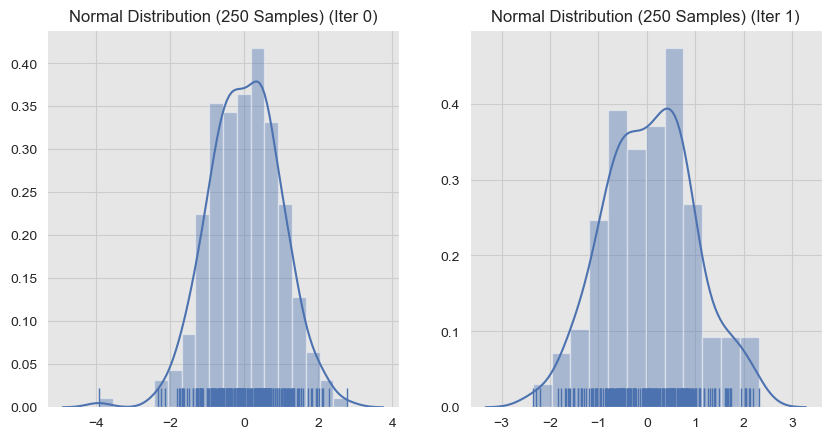

In [5]:
normal_samples = normal.sample([n_samples, n_samples])

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes = axes.flatten()

for i in range(2):
    sns.distplot(a=normal_samples[i], color=sns_c[0], rug=True, ax=axes[i])
    axes[i].set(title=f'Normal Distribution ({n_samples} Samples) (Iter {i})')

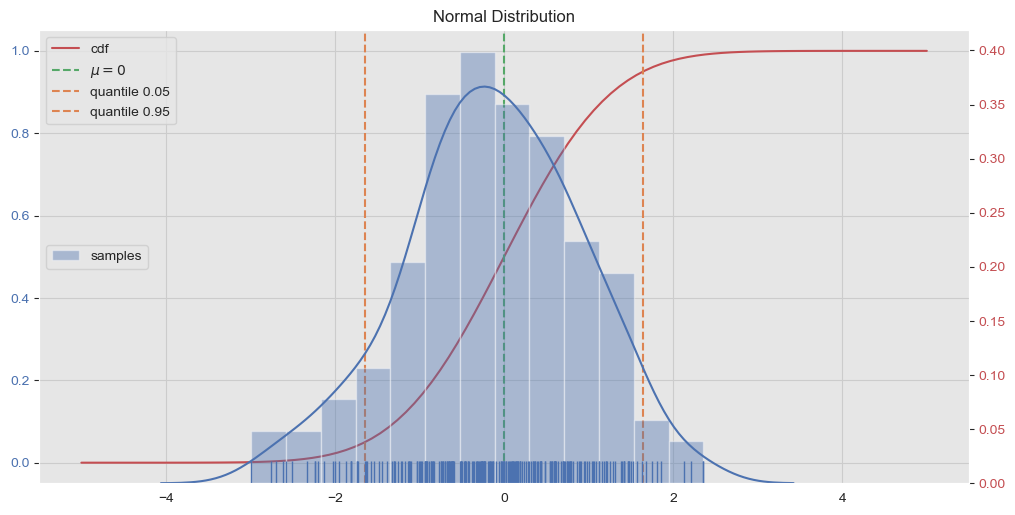

In [6]:
x = tf.linspace(start=-5.0, stop=5.0, num=100)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx() 
sns.lineplot(x=x, y=normal.cdf(x), color=sns_c[3], label='cdf', ax=ax1)
sns.distplot(a=normal.sample(n_samples), color=sns_c[0], label='samples', rug=True, ax=ax2)
ax1.axvline(x=0.0, color=sns_c[2], linestyle='--', label=r'$\mu=0$')

q_list = [0.05, 0.95]
quantiles = normal.quantile(q_list).numpy()
for i, q in zip(q_list , quantiles):
    ax1.axvline(x=q, color=sns_c[1], linestyle='--', label=f'quantile {i}')

ax1.tick_params(axis='y', labelcolor=sns_c[0])
ax2.grid(None)
ax2.tick_params(axis='y', labelcolor=sns_c[3])
ax1.legend(loc='upper left')
ax2.legend(loc='center left')
ax1.set(title='Normal Distribution');

In [7]:
loc_list = np.linspace(start=0.0, stop=8.0, num=5)

normals = tfd.Normal(loc=loc_list, scale=1.0)

normal_samples = normals.sample(n_samples)

normal_samples.shape

TensorShape([250, 5])

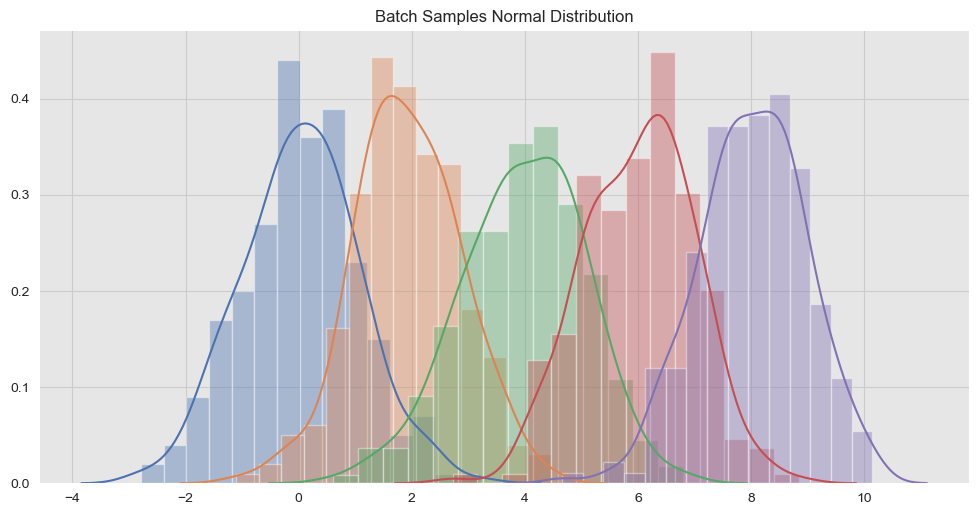

In [8]:
fig, ax = plt.subplots()

for i in range(normals.batch_shape[0]):
    sns.distplot(a=normal_samples[:, i], ax=ax)
ax.set(title='Batch Samples Normal Distribution');

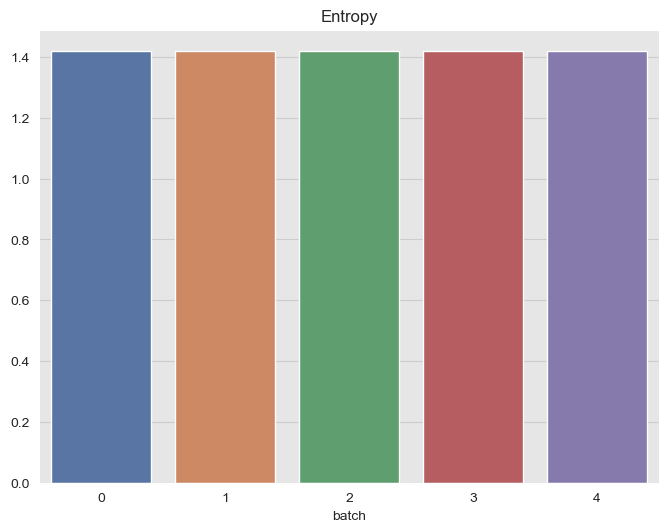

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=list(range(normals.batch_shape[0])), y=normals.entropy(), ax=ax)
ax.set(title='Entropy', xlabel='batch');

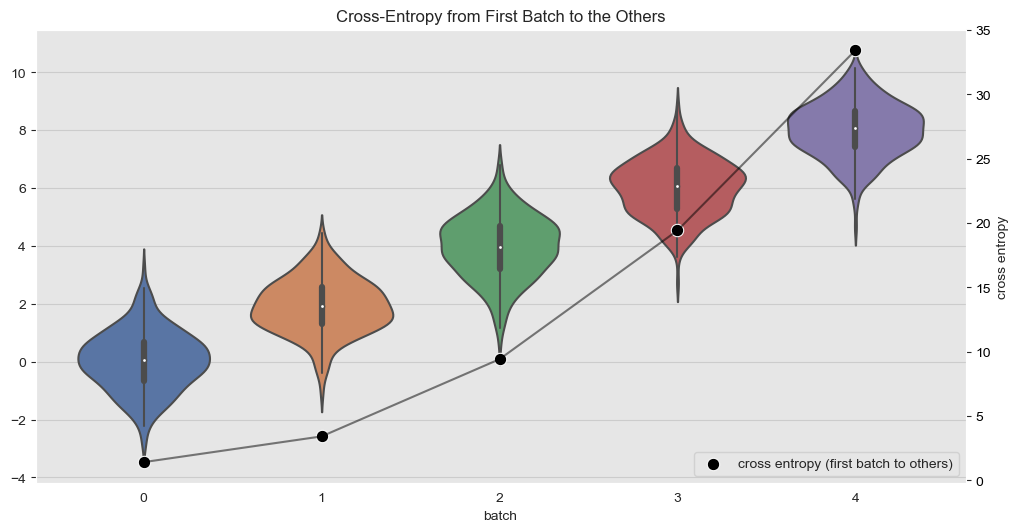

In [10]:
fig, ax1 = plt.subplots()

sns.violinplot(data=normal_samples, ax=ax1)

ax2 = ax1.twinx()
sns.lineplot(x=range(normals.batch_shape[0]), y=normals[0].cross_entropy(normals), color='black',  alpha=0.5, ax=ax2)
sns.scatterplot(x=range(normals.batch_shape[0]), y=normals[0].cross_entropy(normals), s=80, color='black', label='cross entropy (first batch to others)', ax=ax2)

ax2.grid(None)
ax2.legend(loc='lower right')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set(ylabel='cross entropy')
ax1.set(title='Cross-Entropy from First Batch to the Others', xlabel='batch');

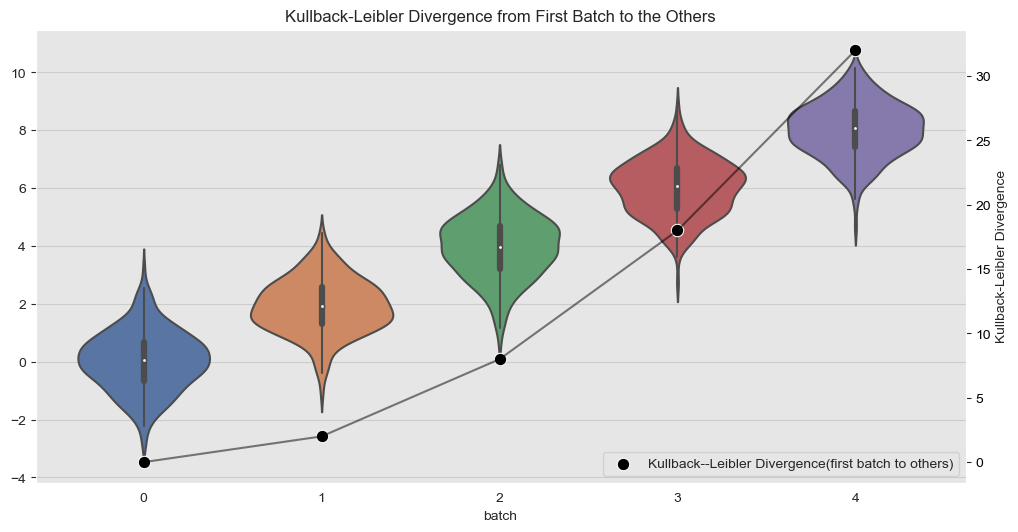

In [11]:
fig, ax1 = plt.subplots()

sns.violinplot(data=normal_samples, ax=ax1)

ax2 = ax1.twinx()
sns.lineplot(x=range(normals.batch_shape[0]), y=normals[0].kl_divergence(normals), color='black',  alpha=0.5, ax=ax2)
sns.scatterplot(x=range(normals.batch_shape[0]), y=normals[0].kl_divergence(normals), s=80, color='black', label='Kullback--Leibler Divergence(first batch to others)', ax=ax2)

ax2.grid(None)
ax2.legend(loc='lower right')
ax2.tick_params(axis='y', labelcolor='black')
ax2.set(ylabel='Kullback-Leibler Divergence')
ax1.set(title='Kullback-Leibler Divergence from First Batch to the Others', xlabel='batch');

In [12]:
mu = [1.0, 2.0]

cov = [[2.0, 1.0],
       [1.0, 1.0]]

cholesky = tf.linalg.cholesky(cov)

multi_normal = tfd.MultivariateNormalTriL(loc=mu, scale_tril=cholesky)

multi_normal_samples = multi_normal.sample(n_samples)

Text(0.5, 1.04, 'Multinormal Samples')

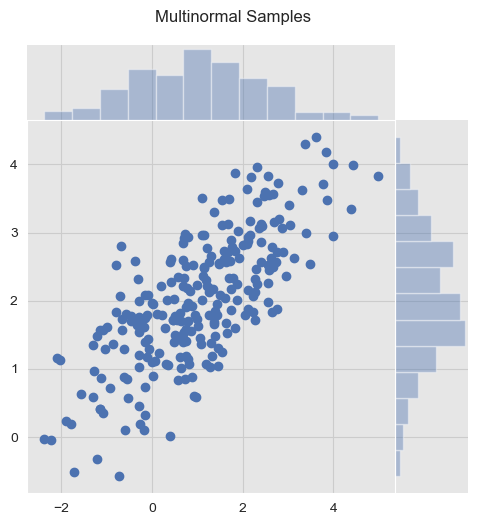

In [13]:
g = sns.jointplot(
    x=multi_normal_samples[:,0], 
    y=multi_normal_samples[:, 1], 
    space=0,
    height=5,
)

g.fig.suptitle('Multinormal Samples', y=1.04)

In [14]:
kernel = tfp.math.psd_kernels.ExponentiatedQuadratic(amplitude=1, length_scale=1)
xs = tf.reshape(tf.linspace(0.0, 10.0, 200), [-1, 1])
gp = tfd.GaussianProcess(kernel=kernel, index_points=xs)

In [15]:
gp_samples = gp.sample(7)

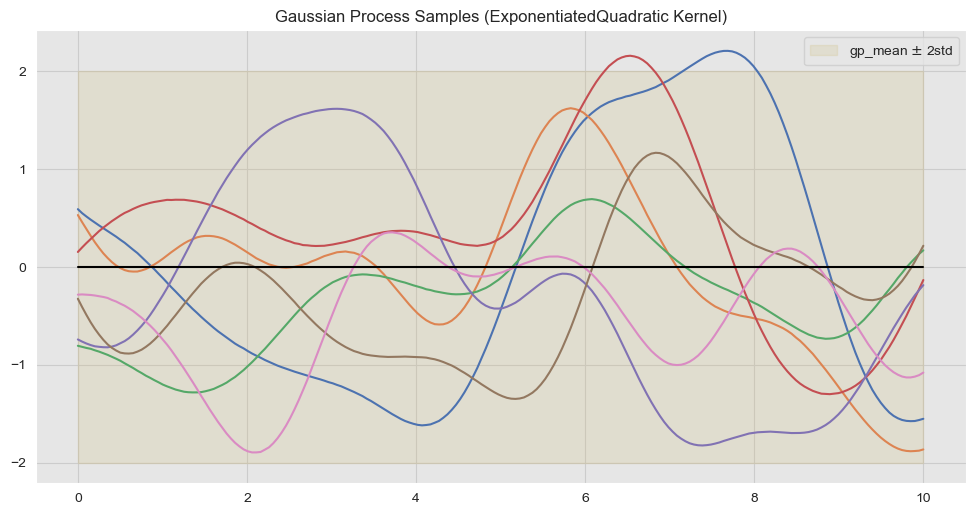

In [16]:
fig, ax = plt.subplots()

for i in range(7):
    sns.lineplot(x=xs[..., 0], y=gp_samples[i, :], color=sns_c[i], ax=ax)

sns.lineplot(x=tf.reshape(xs, [-1]), y=gp.mean(), color='black', ax=ax)

upper, lower = gp.mean() + [2 * gp.stddev(), -2 * gp.stddev()]
ax.fill_between(xs[..., 0], upper, lower, color=sns_c[8], alpha=0.2, label=r'gp_mean $\pm$ 2std')

ax.legend()
ax.set(title='Gaussian Process Samples (ExponentiatedQuadratic Kernel)');